<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced MetPy: Quasi-Geostrophic Analysis</h1>
<h2>Brian: hacked up and incomplete...</h2>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Objectives
1. <a href="#download">Download data from TDS</a>
1. <a href="#interpolation">Calculate QG-Omega Forcing Terms</a>
1. <a href="#ascent">Create a four-panel plot of QG Forcings</a>

This is a tutorial demonstrates common analyses for Synoptic Meteorology courses with use of Unidata tools, specifically [MetPy](https://unidata.github.io/MetPy/latest/) and [Siphon](https://unidata.github.io/siphon/latest/). In this tutorial we will cover accessing, calculating, and plotting model output.

Let's investigate The Storm of the Century, although it would easy to change which case you wanted (please feel free to do so).

Reanalysis Output: NARR 00 UTC 13 March 1993

### Data from Reanalysis on pressure surfaces:
* Geopotential Heights
* Temperature
* u-wind component
* v-wind component

### Calculations:
* Laplacian of Temperature Advection
* Differential Vorticity Advection
* Wind Speed

In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconstants
import numpy as np
import xarray as xr

from metpy.units import units
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [43]:
# Specify our date/time of product desired
dt = datetime(2014, 7, 18, 12)

# Construct our OPeNDAP access URL
base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-namanl-old/'
data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
                       f'namanl_218_{dt:%Y%m%d}_{dt:%H}00_000.grb',
                       decode_times=True)

In [51]:
variables = [
    'Temperature_isobaric',
    'Geopotential_height_isobaric',
    'u-component_of_wind_isobaric',
    'v-component_of_wind_isobaric',
]
ds=data[variables]

In [63]:
ds

<xarray.Dataset>
Dimensions:                       (time1: 1, isobaric: 39, y: 428, x: 614)
Coordinates:
  * x                             (x) float32 -4.224e+03 ... 3.249e+03
  * y                             (y) float32 -832.2 -820.0 ... 4.373e+03
    reftime                       datetime64[ns] ...
  * time1                         (time1) datetime64[ns] 2014-07-18T12:00:00
  * isobaric                      (isobaric) float32 50.0 75.0 ... 975.0 1e+03
Data variables:
    Temperature_isobaric          (time1, isobaric, y, x) float32 ...
    Geopotential_height_isobaric  (time1, isobaric, y, x) float32 ...
    u-component_of_wind_isobaric  (time1, isobaric, y, x) float32 ...
    v-component_of_wind_isobaric  (time1, isobaric, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,129
    Generating_process_or_model:          MESO NAM Model (currently 12 km)
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID

In [62]:
avor = mpcalc.absolute_vorticity(ds['u-component_of_wind_isobaric'], 
                                 ds['v-component_of_wind_isobaric'],
                                latitude=ds['lat'])
avor

KeyError: 'lat'

### QG Omega Forcing Terms

Here is the QG Omega equation from Bluesetein (1992; Eq. 5.6.11) with the two primary forcing terms on the right hand side of this equation.

$$\left(\nabla_p ^2 + \frac{f^2}{\sigma}\frac{\partial ^2}{\partial p^2}\right)\omega = 
\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right] +
\frac{R}{\sigma p} \nabla_p ^2 \left[\vec{V_g} \cdot \nabla_p T \right]$$

We want to write code that will calculate the differential vorticity advection term (the first term on the r.h.s.) and the laplacian of the temperature advection. We will compute these terms so that they are valid at 700 hPa. Need to set constants for static stability, f0, and Rd.

In [53]:
# Set constant values that will be needed in computations

# Set default static stability value
sigma = 2.0e-6 * units('m^2 Pa^-2 s^-2')

# Set f-plane at typical synoptic f0 value
f0 = 1e-4 * units('s^-1')

# Use dry gas constant from MetPy constants
Rd = mpconstants.Rd

#### Compute Term A - Differential Vorticity Advection

Need to compute:
1. absolute vorticity at two levels (e.g., 500 and 900 hPa)
2. absolute vorticity advection at same two levels
3. centered finite-difference between two levels (e.g., valid at 700 hPa)
4. apply constants to calculate value of full term

In [11]:
# Absolute Vorticity Calculation
avor_900 = mpcalc.absolute_vorticity(ds.u, vwnd_900s, dx, dy, lats)
avor_500 = mpcalc.absolute_vorticity(uwnd_500s, vwnd_500s, dx, dy, lats)

# Advection of Absolute Vorticity
vortadv_900 = mpcalc.advection(avor_900, (uwnd_900s, vwnd_900s), (dx, dy)).to_base_units()
vortadv_500 = mpcalc.advection(avor_500, (uwnd_500s, vwnd_500s), (dx, dy)).to_base_units()

# Differential Vorticity Advection between two levels
diff_avor = ((vortadv_900 - vortadv_500)/(400 * units.hPa)).to_base_units()

# Calculation of final differential vorticity advection term
term_A = (-f0 / sigma * diff_avor).to_base_units()
print(term_A.units)

kilogram / meter ** 3 / second ** 3


<div class="alert alert-success">
    <b>EXERCISE</b>:

Compute Term B - Laplacian of Temperature Advection
    
Need to compute:
    
 <ul>
     <li>Temperature advection at 700 hPa (tadv_700)</li>
     <li>Laplacian of Temp Adv. at 700 hPa (lap_tadv_700)</li>
     <li>Final term B with appropriate constants (term_B)</li>
</ul>
    
For information on how to calculate a Laplacian using MetPy, see the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.laplacian.html">documentation</a> on this function.
</div>

In [12]:
# Temperature Advection


# Laplacian of Temperature Advection


# Calculation of final Laplacian of Temperature Advection term



<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [13]:
# %load solutions/term_B_calc.py

# Cell content replaced by load magic replacement.
# 700-hPa Temperature Advection
tadv_700 = mpcalc.advection(tmpk_700s, (uwnd_700s, vwnd_700s), (dx, dy)).to_base_units()
# Laplacian of Temperature Advection
lap_tadv_700 = mpcalc.laplacian(tadv_700, deltas=(dy, dx))

# Final term B calculation with constants
term_B = (-Rd / (sigma * (700 * units.hPa)) * lap_tadv_700).to_base_units()
print(term_B.units)


kilogram / meter ** 3 / second ** 3


### Four Panel Plot

Upper-left Panel: 700-hPa Geopotential Heights, Temperature, and Winds

Upper-right Panel: 500-hPa Geopotential Heights, Absolute Vorticity, and Winds

Lower-left Panel: Term B (Laplacian of Temperature Advection)

Lower-right Panel: Term A (Laplacian of differential Vorticity Advection)

In [14]:
# Set some contour intervals for various parameters

# CINT 500 hPa Heights
clev_hght_500 = np.arange(0, 7000, 60)
# CINT 700 hPa Heights
clev_hght_700 = np.arange(0, 7000, 30)
# CINT 700 hPa Temps
clev_tmpc_700 = np.arange(-40, 40, 5)
# CINT Omega terms
clev_omega = np.arange(-20, 21, 2)

In [15]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

#### Start 4-panel Figure

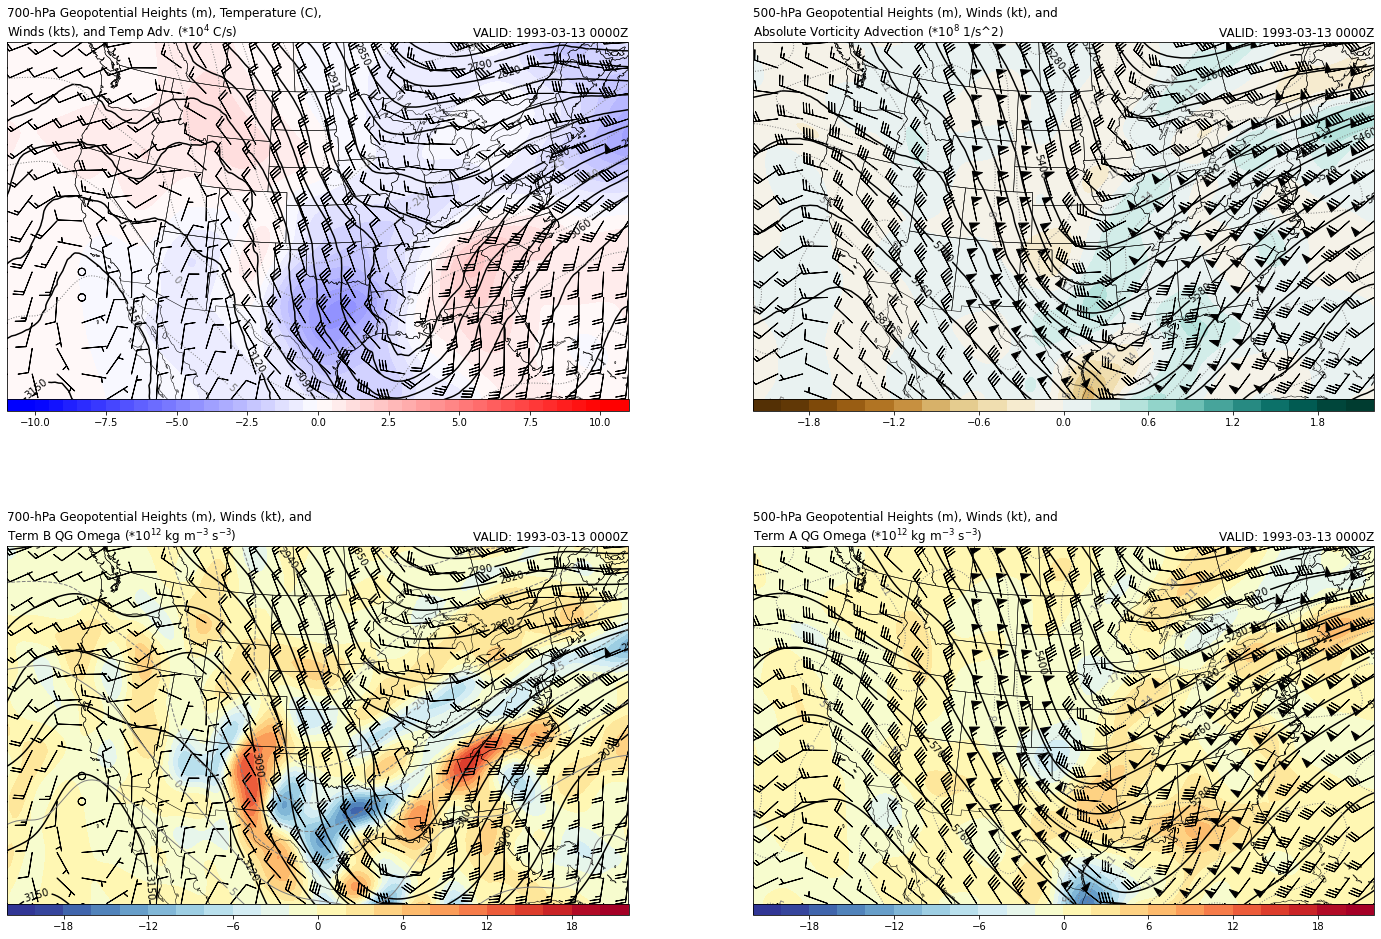

In [16]:
# Set figure size
fig=plt.figure(1, figsize=(24.5,17.))

# Format the valid time
vtime_str = str(vtime.dt.strftime('%Y-%m-%d %H%MZ').values)

# Upper-Left Panel
ax=plt.subplot(221, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_700, clev_hght_700,colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, tadv_700*10**4, np.arange(-10,10.1,0.5),
                 cmap=plt.cm.bwr, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons.m, lats.m, uwnd_700s.to('kts').m, vwnd_700s.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights (m), Temperature (C),\n'
          'Winds (kts), and Temp Adv. ($*10^4$ C/s)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')



# Upper-Right Panel
ax=plt.subplot(222, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lons, lats, hght_500, clev500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, avor_500*10**5, np.arange(-40, 50, 3),colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, vortadv_500*10**8, np.arange(-2, 2.2, 0.2),
                 cmap=plt.cm.BrBG, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons.m, lats.m, uwnd_500s.to('kts').m, vwnd_500s.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Absolute Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')



# Lower-Left Panel
ax=plt.subplot(223, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, term_B*10**12, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons.m, lats.m, uwnd_700s.to('kts').m, vwnd_700s.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Term B QG Omega ($*10^{12}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')



# # Lower-Right Panel
ax=plt.subplot(224, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_500s, clev500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, avor_500*10**5, np.arange(-40, 50, 3), colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, term_A*10**12, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons.m, lats.m, uwnd_500s.to('kt').m, vwnd_500s.to('kt').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights (m), Winds (kt), and\n'
          'Term A QG Omega ($*10^{12}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li>Plot the combined QG Omega forcing terms (term_A + term_B) in a single panel.</li>
         <li><b>BONUS:</b> Compute a difference map of Term A and Term B and plot.</li>
    </ul>
</div>

In [17]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [18]:
# %load solutions/qg_omega_total_fig.py

# Cell content replaced by load magic replacement.
fig=plt.figure(1, figsize=(15.,12.))

# Upper-Left Panel
ax=plt.subplot(111,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES,linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_700s, clev_hght_700,colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, (term_A+term_B)*10**12, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons.m, lats.m, uwnd_700s.to('kts').m, vwnd_700s.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('700-hPa Geopotential Heights, Temperature (C),\n'
          'Winds (kt), and QG Omega Forcings ($*10^{12}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title('VALID: ' + vtime_str, loc='right')

plt.show()
